In [8]:
# imports

## allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys
import os

if ".." not in sys.path:
    sys.path.insert(0, "..")
from imports import *

logger = logging.getLogger()
logger.setLevel(level=logging.WARN)

__builtins__.verbosity = 4
# Set the HF_HOME environment variable
os.environ["HF_HOME"] = "/run/media/HUNK/DATASETS/HF"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from lib.chess import chess_move_labels as le


class params:
    num_workers = 24
    files_per_epoch = 24
    max_games_per_file = 250
    # batch_size = 160
    batch_size = 64
    seq_len = 140

    max_epochs = 40
    # lr = 0.005
    lr = 0.0005

    flush_epoch_units = False
    loss_every = 20
    vocab_size = len(le.classes_)


In [15]:
# load rwkv

from models.nanoRWKV import *

rwkv_model = RWKV(GPTConfig.create(params, bias=True))

rwkv_model.load_from_pth(
    "out/RWKV__seq_len=140__vocab_size=7797__n_layer=12__n_head=12__n_embd=768__dropout=0.0__bias=True__lr=0.005__weight_decay=0.01__epoch=89-135.pth"
)

rwkv_model.to(device)

index = 9
model = rwkv_model

layer = model.transformer.h[index].tmix


number of parameters: 91.13M


In [25]:
# load gpt
from models.nanoGPT import *


gpt_model = GPT(GPTConfig.create(params, bias=True))

gpt_model.load_from_pth(
    "out/GPT__seq_len=140__vocab_size=7797__n_layer=12__n_head=12__n_embd=768__dropout=0.0__bias=True__lr=0.005__weight_decay=0.01__epoch=86-132.pth"
)
gpt_model.to(device)


In [16]:
from data.pgnSquare import *

dt = PGNSquareData(PGNSquareDataConfig.create(params))
# dt.preview(samples=20)

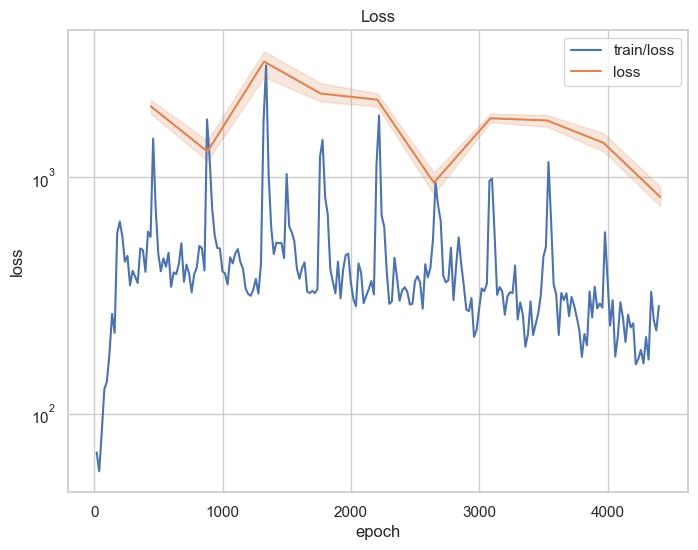

Epochs progress:   0%|          | 0/40 [00:00<?, ?Epoch/s]

In [ ]:
from models.linear_probe import *


probe = LinearProbe(model, layer, ProbeConfig(n_classes=dt.classes))

trainer = ProbeTrainer(
    TrainerConfig.create(
        params,
        epoch_end_callback=[
            dt.shuffle_files,
        ],
    )
)

trainer.fit(probe, dt.loaders())